In [1]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

df = pd.read_csv('/Users/varnika/Desktop/harvard/all_var_int.csv')
pd.set_option('display.max_columns', None)

/Users/varnika/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/var/folders/gw/xg9wcgln7x1f2k7qpz6vkm_c0000gn/T/ipykernel_52046/1522025319.py:7: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/varnika/Desktop/harvard/all_var_int.csv')


In [2]:
avalanche_sens_vars = [
    "kutchha_ratio",
    "anaemic_pregnant_ratio",
    "anaemic_adolescent_ratio",
    "sc_ratio",
    "st_ratio",
    "hh_non_farm_ratio",
    "pmuy_ratio"
]


In [3]:
import pandas as pd

id_cols = ["state_code", "district_code", "block_code", "FID_Key"]
avalanche_sens_cols = id_cols + avalanche_sens_vars

# Subset from your master DataFrame (assumed to be `df`)
avalanche_sens_df = df[avalanche_sens_cols].copy()

# Check missingness
print(avalanche_sens_df.isna().sum())


state_code                  0
district_code               0
block_code                  0
FID_Key                     0
kutchha_ratio               0
anaemic_pregnant_ratio      0
anaemic_adolescent_ratio    0
sc_ratio                    0
st_ratio                    0
hh_non_farm_ratio           0
pmuy_ratio                  0
dtype: int64


In [4]:
from sklearn.preprocessing import RobustScaler

Rscaler = RobustScaler()

# Scale only the avalanche_sens_vars
features_only = avalanche_sens_df[avalanche_sens_vars].astype(float).values
features_scaled = Rscaler.fit_transform(features_only)

# Create scaled DataFrame
sens_scaled = pd.DataFrame(features_scaled,
                           columns=avalanche_sens_vars,
                           index=avalanche_sens_df.index)

# Merge scaled columns back or keep them separate
for col in avalanche_sens_vars:
    avalanche_sens_df[col + "_scaled"] = sens_scaled[col]


In [5]:
from sklearn.decomposition import PCA
import numpy as np

# Collect scaled columns only
sens_pca_vars = [c for c in avalanche_sens_df.columns if c.endswith("_scaled")]
X_sens = avalanche_sens_df[sens_pca_vars].astype(float)

pca = PCA()
pca.fit(X_sens)

# Summarize variance
pcaSummary_aval_sens = pd.DataFrame({
    '% variance': pca.explained_variance_ratio_,
    'Cumulative %': np.cumsum(pca.explained_variance_ratio_)
})
print(pcaSummary_aval_sens.round(3))


   % variance  Cumulative %
0       0.545         0.545
1       0.182         0.728
2       0.089         0.817
3       0.061         0.878
4       0.052         0.930
5       0.036         0.965
6       0.035         1.000


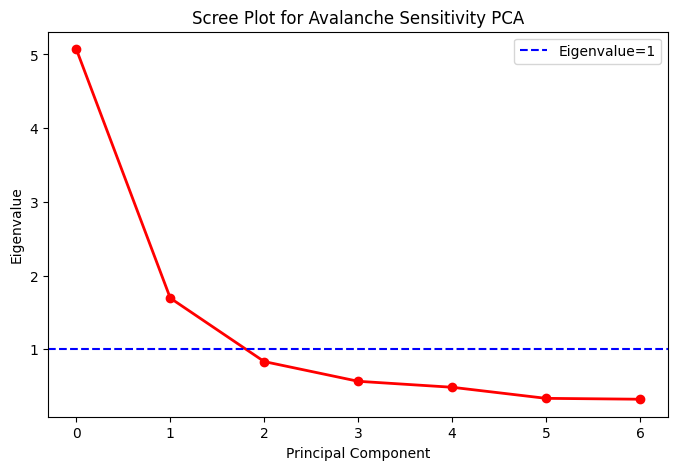

In [6]:
import matplotlib.pyplot as plt

eigenvalues = pca.explained_variance_
xvals = np.arange(len(eigenvalues))

plt.figure(figsize=(8,5))
plt.plot(xvals, eigenvalues, 'ro-', linewidth=2)
plt.title("Scree Plot for Avalanche Sensitivity PCA")
plt.xlabel("Principal Component")
plt.ylabel("Eigenvalue")
plt.axhline(y=1, color='b', linestyle='--', label="Eigenvalue=1")
plt.xticks(xvals)
plt.legend()
plt.show()


In [7]:
n_components = 2  
pca_n = PCA(n_components=n_components)
X_sens_pca = pca_n.fit_transform(X_sens)

# Retrieve top PC variance ratios
pca_weights = pcaSummary_aval_sens['% variance'][:n_components]

# Add PC columns
for i in range(n_components):
    avalanche_sens_df[f"AvalSens_PC{i+1}"] = X_sens_pca[:, i]

# Weighted sum => "Avalanche_Sensitivity_Index"
avalanche_sens_df["Avalanche_Sensitivity_Index"] = 0
for i in range(n_components):
    avalanche_sens_df["Avalanche_Sensitivity_Index"] += (
        pca_weights.iloc[i] * avalanche_sens_df[f"AvalSens_PC{i+1}"]
    )

print(avalanche_sens_df[["block_code", "Avalanche_Sensitivity_Index"]].head())
print(avalanche_sens_df["Avalanche_Sensitivity_Index"].describe())


   block_code  Avalanche_Sensitivity_Index
0        6498                     0.030250
1        6492                    -0.261866
2        4689                    -0.366185
3        4690                    -0.065119
4        4692                    -0.373705
count    5.815000e+03
mean    -3.421358e-17
std      1.250862e+00
min     -1.546655e+00
25%     -5.403753e-01
50%     -4.289475e-01
75%      2.089643e-02
max      5.711832e+01
Name: Avalanche_Sensitivity_Index, dtype: float64


In [8]:
loadings_sens = pd.DataFrame(
    pca_n.components_.T,
    index=sens_pca_vars,
    columns=[f"PC{i+1}" for i in range(n_components)]
)
print(loadings_sens)


                                      PC1       PC2
kutchha_ratio_scaled             0.177005 -0.151988
anaemic_pregnant_ratio_scaled    0.093499 -0.558741
anaemic_adolescent_ratio_scaled  0.118785 -0.719411
sc_ratio_scaled                 -0.135134  0.023548
st_ratio_scaled                  0.959360  0.203338
hh_non_farm_ratio_scaled        -0.075595  0.269102
pmuy_ratio_scaled                0.038349 -0.181216
